# Get GPU Info

In [1]:
!nvidia-smi

Mon Jul  5 08:31:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installation

In [2]:
# !pip install transformers
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install accelerate

# Imports

In [4]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm.auto import tqdm
from google.colab import files
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import random
pd.set_option('display.max_columns', None)
np.seterr(divide='ignore', invalid='ignore')

# Visualizations
from plotly.subplots import make_subplots
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Machine Leaning
# Utils
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
# NLP
from transformers import AutoTokenizer, AutoModel
#Metrics
from sklearn.metrics import f1_score, roc_auc_score

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


# Reading File

In [5]:
text_df = pd.read_csv('./Dataset/SMSSpamCollection.csv', names=['Class', 'Text'])
text_df.sample(10)

,Class,Text
3245,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
944,ham,And also I've sorta blown him off a couple tim...
1044,ham,Mmm thats better now i got a roast down me! i...
2484,ham,Mm have some kanji dont eat anything heavy ok
812,ham,So there's a ring that comes with the guys cos...
2973,ham,Sary just need Tim in the bollox &it hurt him ...
2991,ham,"Love isn't a decision, it's a feeling. If we c..."
2942,ham,My supervisor find 4 me one lor i thk his stud...
230,ham,Dear good morning now only i am up
1181,ham,I'm in chennai velachery:)


## Encoding the Class

In [6]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(text_df['Class'])
text_df['class_encoded']=integer_encoded
text_df.sample(10)

,Class,Text,class_encoded
1086,ham,FR'NDSHIP is like a needle of a clock. Though ...,0
483,ham,Watching tv lor...,0
855,ham,Stop the story. I've told him i've returned it...,0
4652,spam,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...,1
1859,ham,"Sir, i am waiting for your call.",0
398,ham,You are always putting your business out there...,0
5258,ham,1 in cbe. 2 in chennai.,0
1170,ham,Msgs r not time pass.They silently say that I ...,0
5425,ham,Otherwise had part time job na-tuition..,0
2767,spam,Married local women looking for discreet actio...,1


# Text Cleaning

In [7]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes RT in case of Re-Tweets
    4. Removes Numbers
    5. Removes embedded URL links
    6. Removes HTML tags
    7. Removes emojis
    8. Makes all text lower case
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\d\s]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = re.sub(r"RT ", " ", text) #Remove RT for Re-tweets
    text = re.sub(r"[0-9]", " ", text) #Remove Numbers
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

In [8]:
tqdm.pandas()
text_df['Text'] = text_df['Text'].progress_apply(text_cleaning)

In [9]:
text_df.sample(10)

,Class,Text,class_encoded
577,ham,i m tired of arguing with you about this week ...,0
2279,ham,hmm bad news hype park plaza studio taken ...,0
4517,spam,congrats mobile g videophones r yours call ...,1
4206,spam,important information orange user xxxxxx...,1
2771,ham,no problem talk to you later,0
3678,ham,great so what attracts you to the brothas,0
2590,spam,join the uk s horniest dogging service and u c...,1
2569,ham,hey for me there is no leave on friday wait i ...,0
1209,ham,also maaaan are you missing out,0
4743,ham,ya very nice be ready on thursday,0


# EDA

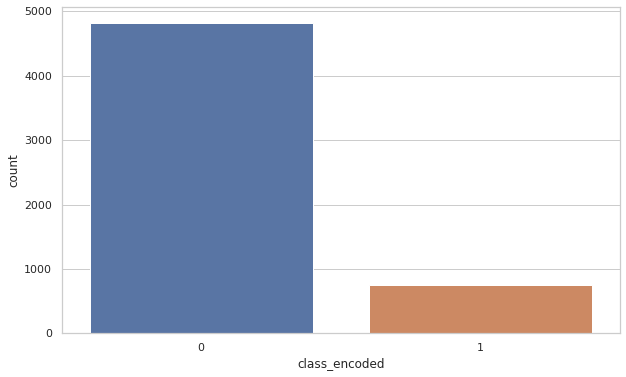

In [10]:
barplot_dim = (10, 6)
ax = plt.subplots(figsize=barplot_dim)
sns.countplot(x='class_encoded', data=text_df);

# CFG

In [11]:
params = {
    'checkpoint': 'bert-base-uncased',
    'output_logits': 768,
    'max_len': 128,
    'num_folds': 5,
    'batch_size': 32,
    'dropout': 0.1,
    'num_workers': 2,
    'epochs': 5,
    'lr': 2e-5,
    'scheduler_name': 'OneCycleLR',
    'max_lr': 5e-5,                 # OneCycleLR
    'pct_start': 0.1,               # OneCycleLR
    'anneal_strategy': 'cos',       # OneCycleLR
    'div_factor': 1e3,              # OneCycleLR
    'final_div_factor': 1e3,        # OneCycleLR
}

# Dataset

In [12]:
class BERTDataset:
  def __init__(self, texts, labels, max_len=params['max_len'], checkpoint=params['checkpoint']):
    self.texts = texts
    self.labels = labels
    self.max_len = max_len
    self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    self.num_examples = len(self.texts)

  def __len__(self):
    return self.num_examples

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]
    tokenized_text = self.tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=self.max_len,
    )
    ids = tokenized_text['input_ids']
    mask = tokenized_text['attention_mask']
    token_type_ids = tokenized_text['token_type_ids']

    return {'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(label, dtype=torch.float)}

# Scheduler

In [13]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(df_train.shape[0] / params['batch_size']) + 1,
            epochs=scheduler_params['epochs'],
            pct_start=scheduler_params['pct_start'],
            anneal_strategy=scheduler_params['anneal_strategy'],
            div_factor=scheduler_params['div_factor'],
            final_div_factor=scheduler_params['final_div_factor'],
        )
    return scheduler

# NLP Model

In [14]:
class SpamDetector(nn.Module):
  def __init__(self, checkpoint=params['checkpoint'], params=params):
    super(SpamDetector, self).__init__()
    self.bert = AutoModel.from_pretrained(checkpoint, return_dict=False)
    self.dropout = nn.Dropout(params['dropout'])
    self.classifier = nn.Linear(params['output_logits'], 1)

  def forward(self, input_ids, token_type_ids, attention_mask):
    _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

# Metrics

In [15]:
def usr_f1_score(output, target):
  try:
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()
    y_pred = (y_pred>0.5)
    target = target.cpu()
    return f1_score(target, y_pred)
  except:
    return 0.5

In [16]:
def usr_roc_score(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()
        return roc_auc_score(target, y_pred)
    except:
        return 0.5

# Training And Validation Function

In [17]:
def train(model, device, train_dataset, valid_dataset, params=params, epochs=params['epochs'], scheduler=params['scheduler_name']):
  model.to(device)
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]
  optimizer = optim.AdamW(optimizer_grouped_parameters, lr=params['lr'])
  
  if scheduler is not None:
      scheduler = get_scheduler(optimizer)
  
  criterion = nn.BCEWithLogitsLoss()

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_f1 = 0
    train_roc = 0
    stream_1 = tqdm(train_dataset)
    stream_1.set_description('Training')
    for batch in stream_1:
      optimizer.zero_grad()
      ids = batch['ids'].to(device)
      mask = batch['mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      target = batch['target'].to(device)
      logits = model(ids, token_type_ids, mask)
      loss = criterion(logits, target.view(-1, 1))
      f1_score = usr_f1_score(logits, target)
      roc_score = usr_roc_score(logits, target)
      loss.backward()
      optimizer.step()
      if scheduler is not None:
        scheduler.step()
      train_loss += loss.item() * batch['ids'].size(0)
      train_f1 += f1_score
      train_roc += roc_score
      stream_1.update(1)
    
    train_loss/= len(train_dataset)
    train_f1 /= len(train_dataset)
    train_roc /= len(train_dataset)

    model.eval()
    valid_loss = 0
    valid_f1 = 0
    valid_roc = 0
    stream_2 = tqdm(valid_dataset)
    stream_2.set_description('Validating')
    for batch in stream_2:
      ids = batch['ids'].to(device)
      mask = batch['mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      target = batch['target'].to(device)
      logits = model(ids, token_type_ids, mask)
      loss = criterion(logits, target.view(-1, 1))
      f1_score = usr_f1_score(logits, target)
      roc_score = usr_roc_score(logits, target)
      valid_loss += loss.item() * batch['ids'].size(0)
      valid_f1 += f1_score
      valid_roc += roc_score
      stream_2.update(1)

    valid_loss /= len(valid_dataset)
    valid_f1 /= len(valid_dataset)
    valid_roc /= len(valid_dataset)

    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train Loss: {train_loss:.3f}. Validation Loss: {valid_loss:.3f}")
    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train F1: {train_f1:.3f}. Validation F1: {valid_f1:.3f}")
    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train ROC: {train_roc:.3f}. Validation ROC: {valid_roc:.3f}")

# Run

In [18]:
text_df["kfold"] = -1
text_df = text_df.sample(frac=1).reset_index(drop=True)
y = text_df.class_encoded.values
kf = StratifiedKFold(n_splits=params['num_folds'])
for f, (t_, v_) in enumerate(kf.split(X=text_df, y=y)):
    text_df.loc[v_, 'kfold'] = f
    
text_df.sample(10)

,Class,Text,class_encoded,kfold
5528,ham,cos darren say considering mah so i ask,0,4
4971,ham,good words but words may leave u in dismay man...,0,4
101,ham,just dropped em off omw back now,0,0
267,ham,wat r u doing,0,0
4361,ham,god s love has no limit god s grace has no mea...,0,3
5204,ham,tick tick tick babe,0,4
1364,spam,free msg sorry a service you ordered from ...,1,1
173,ham,geeeee i love you so much i can barely stand it,0,0
1762,ham,tomarrow i want to got to court at decimal so ...,0,1
3939,ham,oh ok i didnt know what you meant yep i am bab...,0,3


In [19]:
current_fold = 0
df_train = text_df[text_df['kfold'] != current_fold]
df_valid = text_df[text_df['kfold'] == current_fold]

In [20]:
train_dataset = BERTDataset(
    df_train.Text.values,
    df_train.class_encoded.values
)

valid_dataset = BERTDataset(
    df_valid.Text.values,
    df_valid.class_encoded.values
)

train_dataloader = DataLoader(
    train_dataset, batch_size=params['batch_size'], shuffle=True,
    num_workers=params['num_workers'], pin_memory=True
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=params['batch_size'], shuffle=False,
    num_workers=params['num_workers'], pin_memory=True
)

In [21]:
model = SpamDetector()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
train(model, device, train_dataloader, valid_dataloader)


Epoch: 01/05. Train Loss: 8.358. Validation Loss: 1.965
Epoch: 01/05. Train F1: 0.565. Validation F1: 0.939
Epoch: 01/05. Train ROC: 0.854. Validation ROC: 0.997



Epoch: 02/05. Train Loss: 2.198. Validation Loss: 1.033
Epoch: 02/05. Train F1: 0.912. Validation F1: 0.962
Epoch: 02/05. Train ROC: 0.978. Validation ROC: 0.999



Epoch: 03/05. Train Loss: 1.049. Validation Loss: 0.567
Epoch: 03/05. Train F1: 0.954. Validation F1: 0.982
Epoch: 03/05. Train ROC: 0.981. Validation ROC: 1.000



Epoch: 04/05. Train Loss: 0.663. Validation Loss: 0.521
Epoch: 04/05. Train F1: 0.967. Validation F1: 0.985
Epoch: 04/05. Train ROC: 0.990. Validation ROC: 1.000



Epoch: 05/05. Train Loss: 0.485. Validation Loss: 0.498
Epoch: 05/05. Train F1: 0.962. Validation F1: 0.989
Epoch: 05/05. Train ROC: 0.983. Validation ROC: 1.000


**As we can see we have achieved a very high level ferformance using just a vanilla BERT base model with some minor adjustments to the training process.**